# Analyze Results from Classification models

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/2019-05-23-run_classifiers-config.csv) |


<h2>Data and Models</h2>

Some issues that I ran into when trying to run various datasets against different models:

    * Radius Neighbor - documentation suggests that using RadiusNeighborClassifier my be a better choice if the dsmple is not uniform. My data heavily skewed towards 5-stars so I thought I would try this. However, I found that the radius was difficult to set and the value would change depending on sample size and number of features. Also, it was pretty slow to train. At times this would be slowers the Logistic Regression. I finally gave up on using this last night

    * Logistic Regression parameters - I tried using default settings for this which is 100. However, I found that it would not converge on most datasets that I used. Tried 200 then 300. 300 seems to at least come back with results so I stuck with this to start with

    * Time - had issues with this on multiple fronts
        * I found that generating feature files took quite some time especially using ngram. For dataset with 100k examples, it would take 3 to 4 hours to generate the files on my laptop
        * I found that Logistic Regression ran the slowest out of the 3 models. RN sometimes would be slower.  I found that running the models with large dataset look quite a long time. Since I'm running these on my work laptop, I couldn't just leave it running so had to take some measures to cut down on feature sizes. I did run some models on an hold laptop and found that some feature sizes and model combination was taking more than a day to run so had to abandon that as well.
        
    * Storage - generating various feature file without using BoW and TF-IDF was taking up a lot of space on my laptop. I found that once I converted them into BoW or TF-IDF representation, the files would get much smaller. I did run out of storage on my machine multiple times and my program would stop working because of this.
    

<h3>ngram</h3>

I did try to generate features using ngram. However, I did find that this dramatically increased the feature matrix size. For a file that has ~100k entries. 47k unique features (unique word) would generated by BoW or TF-IDF. For the most part I did not use ngram without using min_df and max_df because I had issues with time needed to create feature files, storage, as well as issues with being able to complete the models when I used ngram alone

| Sample Size | Features no ngram | ngram (1,2) | ngram (1,3) |
|------|------|------|---|
| 999 | 3323 | 17k | 32k |

<h3>min_df and max_df</h3>

I found that using these parameters with setting of min_df=0.05 and max_df=0.95 effectively cut down the feature set size drastically. Unfortunately, when I used this setting on review_headlines, the feature size came down to 7. When using this for review body, if we use 100k examples, this reduced it to about 56 features.

<h3>LDA</h3>

Used LDA for topic modeling. Wasn't sure how many topics would be reasonable here. So for now I picked 20 topics. May play around with this more later



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


%matplotlib inline
sns.set_style("ticks")

In [2]:
DATA_FILE="reports/2019-05-24-run_classifiers-report.csv"

report = pd.read_csv(DATA_FILE)
report["total_size"] = report["train_examples"] + report["test_examples"]
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,message,total_size
0,0.374015,0.341891,0.412802,3968.0,0.079861,0.113974,0.061464,1871.0,0.096102,0.126615,...,0.1,84032.0,20.0,0.0,0.459463,0.440226,0.489486,28011.0,NaN,112043.0
1,0.000000,0.000000,0.000000,3968.0,0.000000,0.000000,0.000000,1871.0,0.000000,0.000000,...,6.3,84032.0,20.0,0.0,0.368956,0.282536,0.531541,28011.0,NaN,112043.0
2,0.414704,0.426291,0.403730,3968.0,0.000000,0.000000,0.000000,1871.0,0.000000,0.000000,...,0.1,84032.0,20.0,0.1,0.444613,0.484761,0.564243,28011.0,NaN,112043.0
3,0.392829,0.357276,0.436240,3968.0,0.080057,0.118697,0.060396,1871.0,0.098584,0.136842,...,0.1,84032.0,20.0,0.0,0.465201,0.446248,0.494877,28011.0,NaN,112043.0
4,0.000000,0.000000,0.000000,3968.0,0.000000,0.000000,0.000000,1871.0,0.000000,0.000000,...,5.8,84032.0,20.0,0.0,0.368956,0.282536,0.531541,28011.0,NaN,112043.0


## Description of which models we ran

Description Uses the following format

(classification model)-(column)-(feature extraction method)-(max/min df setting)-(ngram setting)-(sample size)[-(lda)]

    classification model
        which model we used to train and predict
    column
        which column in Amazon Reviews data set we used to create the feature set
    feature extraction method
        bow = Bag of Words
        tfidf = TF-IDF
    max/min df setting
        df_default = default settings for min_df and max_df
        df90 = min_df of 0.05 and max_df of 0.95
        df80 = min_df of 0.10 and max_def of 0.9
    ngram setting
        ngram1 = (1,1)
        ngram12 = (1,2)
        ngram13 = (1,3)
    lda
        Indicates whether LDA was used on top of feature extraction method. Currently using 20 topics

In [3]:
def split_desc(x):
    desc = x["description"]
    s_desc = desc.split("-")
    if len(s_desc) == 6:
        s_desc.append("n/a")
#     print(f'desc: {desc} len: {len(s_desc)}')
    return pd.Series(s_desc)
    

s = report[["description","status", "model_name"]].copy()
new_df = s.apply(split_desc, axis=1)
# get a list of unique models - we will use this later
MODELS = sorted(report["model_name"].drop_duplicates().to_list())
s.join(new_df)

,description,status,model_name,0,1,2,3,4,5,6
0,review_body-bow-df_90-ngram1-112043-52-lda20,success,KNN,review_body,bow,df_90,ngram1,112043,52,lda20
1,review_body-bow-df_90-ngram1-112043-52-lda20,success,RN,review_body,bow,df_90,ngram1,112043,52,lda20
2,review_body-bow-df_90-ngram1-112043-52-lda20,success,LR,review_body,bow,df_90,ngram1,112043,52,lda20
3,review_body-bow-df_90-ngram12-112043-56-lda20,success,KNN,review_body,bow,df_90,ngram12,112043,56,lda20
4,review_body-bow-df_90-ngram12-112043-56-lda20,success,RN,review_body,bow,df_90,ngram12,112043,56,lda20
5,review_body-bow-df_90-ngram12-112043-56-lda20,success,LR,review_body,bow,df_90,ngram12,112043,56,lda20
6,review_body-tfidf-df_90-ngram11-112043-52-lda20,success,KNN,review_body,tfidf,df_90,ngram11,112043,52,lda20
7,review_body-tfidf-df_90-ngram11-112043-52-lda20,success,RN,review_body,tfidf,df_90,ngram11,112043,52,lda20
8,review_body-tfidf-df_90-ngram11-112043-52-lda20,success,LR,review_body,tfidf,df_90,ngram11,112043,52,lda20
9,review_body-tfidf-df_90-ngram12-112043-56-lda20,success,KNN,review_body,tfidf,df_90,ngram12,112043,56,lda20


In [4]:
report["label"] = report.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
# report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])
report = report.sort_values(["label"])

# Failures

Let's look to see if any of our models failed and why

In [5]:
failures = report[report["status"] == "failed"][["label", "message"]]
pd.set_option("display.max_colwidth", 200)
failures.head()

,label,message
25,RN-review_body-bow-df_90-ngram1-112043-52,"No neighbors found for test samples [13774], you can try using larger radius, give a label for outliers, or consider removing them from your dataset."
28,RN-review_body-bow-df_90-ngram12-112043-56,"No neighbors found for test samples [13595, 13774], you can try using larger radius, give a label for outliers, or consider removing them from your dataset."
34,RN-review_body-bow-df_90-ngram13-112043-56,"No neighbors found for test samples [13595, 13774], you can try using larger radius, give a label for outliers, or consider removing them from your dataset."


### For the rest of this notebook, we will only look at successful models

In [6]:
# we will only look at successful models from now on
# report = report[report["status"] == "success"]


# Time to Train Models vs Features

Total time here is time to call .fit() and .predict() on various models

Given the limited dataset, it's looking like KNN is taking shorter amount of time to train as the sample size increases

NOTE: time does not include time to load data file. I'm finding that for a file that has 112043 examples and ngram (1,1) (47k features), it's taking around 2 hours to load on my computer

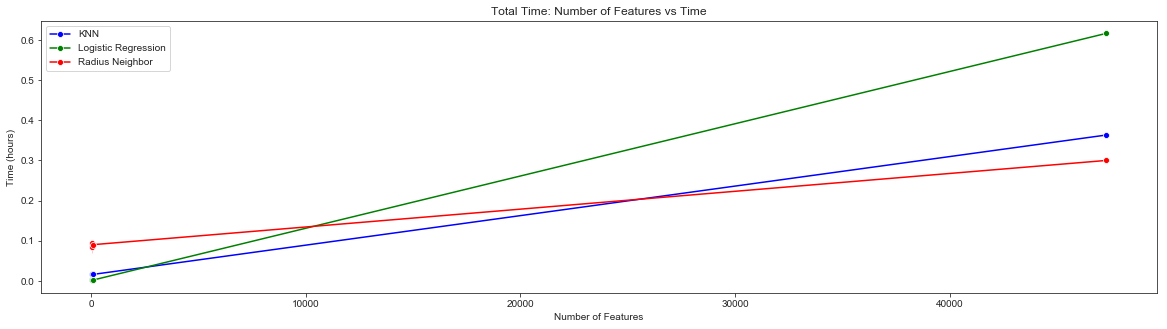

In [7]:
time_df = report[["label", "total_time_min", "train_features"]].copy()
time_df["total_time_hours"] = time_df["total_time_min"] / 60
knn_time_df = time_df[time_df["label"].str.startswith("KNN")]
lr_time_df = time_df[time_df["label"].str.startswith("LR")]
rn_time_df = time_df[time_df["label"].str.startswith("RN")]

f, a = plt.subplots(1, 1, figsize=(20,5))

sns.lineplot(data=knn_time_df, x="train_features", y="total_time_hours", ax=a, color='b', marker='o', label="KNN")
sns.lineplot(data=lr_time_df, x="train_features", y="total_time_hours", ax=a, color='g', marker='o', label="Logistic Regression")
sns.lineplot(data=rn_time_df, x="train_features", y="total_time_hours", ax=a, color='r', marker='o', label="Radius Neighbor")
a.set_title("Total Time: Number of Features vs Time")
a.set_xlabel("Number of Features")
_ = a.set_ylabel("Time (hours)")

## Overall Scores

In [8]:
# set up labels for graphs to follow

MACRO_COLS = [col for col in report.columns if col.startswith("macro")]
MACRO_COLS.append("label")

CLASS_F1_COLS = [col for col in report.columns if len(re.findall(r'^(\d.+score)',col)) > 0]
CLASS_F1_COLS.append("label")

In [9]:
macro_scores = report[MACRO_COLS].copy()
macro_scores.head()

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
15,0.287325,0.299579,0.299892,28011.0,KNN-review_body-bow-df_80-ngram1-112043-20
18,0.287325,0.299579,0.299892,28011.0,KNN-review_body-bow-df_80-ngram12-112043-20
21,0.287325,0.299579,0.299892,28011.0,KNN-review_body-bow-df_80-ngram13-112043-20
24,0.299931,0.304015,0.314862,28011.0,KNN-review_body-bow-df_90-ngram1-112043-52
0,0.281464,0.286897,0.287994,28011.0,KNN-review_body-bow-df_90-ngram1-112043-52-lda20


Text(0.5, 1.0, 'Logistic Regression Macro Average Scores')

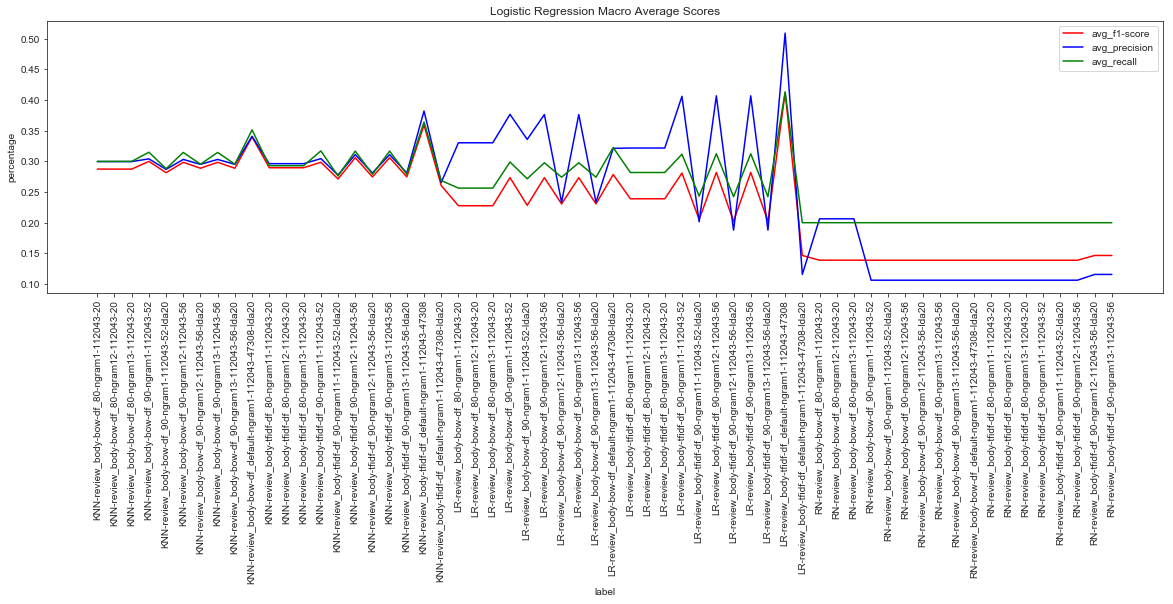

In [10]:
f, a = plt.subplots(1, 1, figsize=(20,5))

g = sns.lineplot(data=macro_scores, x="label", y="macro avg_f1-score", label="avg_f1-score", ax=a, color="r")
g = sns.lineplot(data=macro_scores, x="label", y="macro avg_precision", label="avg_precision", ax=a, color="b")
g = sns.lineplot(data=macro_scores, x="label", y="macro avg_recall", label="avg_recall", ax=a, color="g")
g.set_xticklabels(labels=macro_scores["label"], rotation=90)
g.set_ylabel("percentage")
g.set_title("Logistic Regression Macro Average Scores")


### Looks like for larger data sets compared to just 999 KNN performs better than LR in average F1 scores

In [11]:
for model in MODELS:
    model_df = macro_scores[macro_scores["label"].str.contains("LR")]
    print(f'\n{model} mean: {model_df["macro avg_f1-score"].mean()}')
    print(f'{model} std: {model_df["macro avg_f1-score"].std()}')


KNN mean: 0.24768635128571428
KNN std: 0.05097268739919095

LR mean: 0.24768635128571428
LR std: 0.05097268739919095

RN mean: 0.24768635128571428
RN std: 0.05097268739919095


### Top 5 Models and Datasets with Highest Average F1 Score

In [12]:
macro_scores.nlargest(5, "macro avg_f1-score")

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
62,0.412089,0.508952,0.413149,5018.0,LR-review_body-tfidf-df_default-ngram1-112043-47308
60,0.359072,0.382006,0.364000,5018.0,KNN-review_body-tfidf-df_default-ngram1-112043-47308
57,0.339843,0.340800,0.351246,28011.0,KNN-review_body-bow-df_default-ngram1-112043-47308-lda20
48,0.305915,0.310944,0.316712,28011.0,KNN-review_body-tfidf-df_90-ngram12-112043-56
51,0.305915,0.310944,0.316712,28011.0,KNN-review_body-tfidf-df_90-ngram13-112043-56


## F1 Score By Class

In [13]:
f1_class = report[CLASS_F1_COLS]
f1_class.head()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score,label
15,0.398262,0.075124,0.085801,0.179956,0.697482,KNN-review_body-bow-df_80-ngram1-112043-20
18,0.398262,0.075124,0.085801,0.179956,0.697482,KNN-review_body-bow-df_80-ngram12-112043-20
21,0.398262,0.075124,0.085801,0.179956,0.697482,KNN-review_body-bow-df_80-ngram13-112043-20
24,0.424824,0.094075,0.117705,0.185612,0.677441,KNN-review_body-bow-df_90-ngram1-112043-52
0,0.374015,0.079861,0.096102,0.174777,0.682566,KNN-review_body-bow-df_90-ngram1-112043-52-lda20


In [14]:
# split into different training models
LR = report[report["label"].str.startswith("LR")]
KNN = report[report["label"].str.startswith("KNN")]
RN = report[report["label"].str.startswith("RN")]

## Let's look at F1 scores per class for each training model

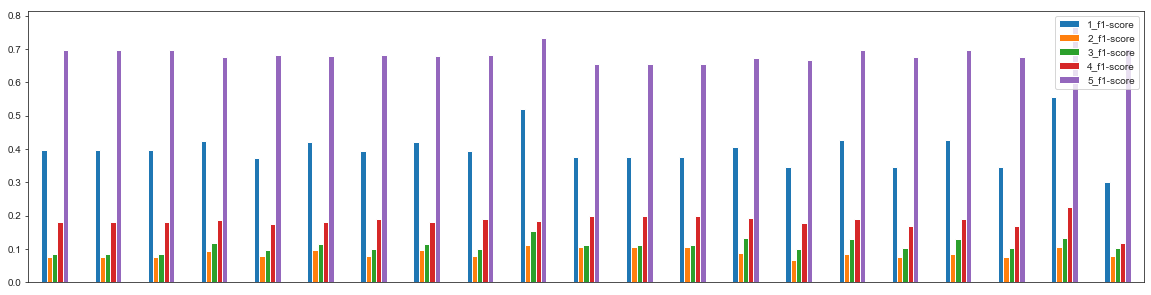

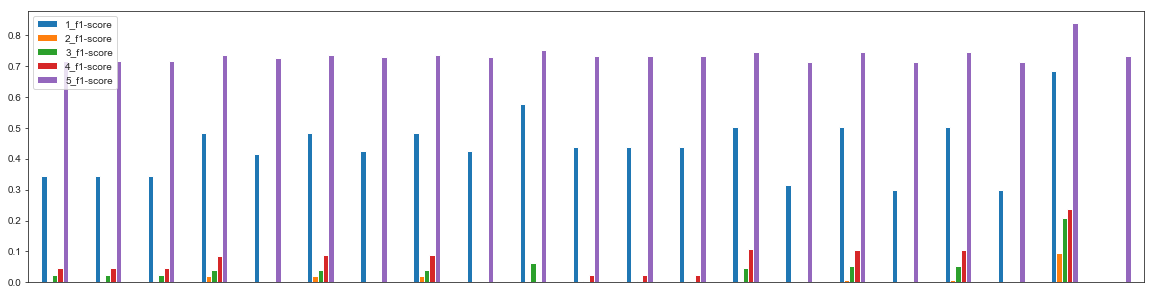

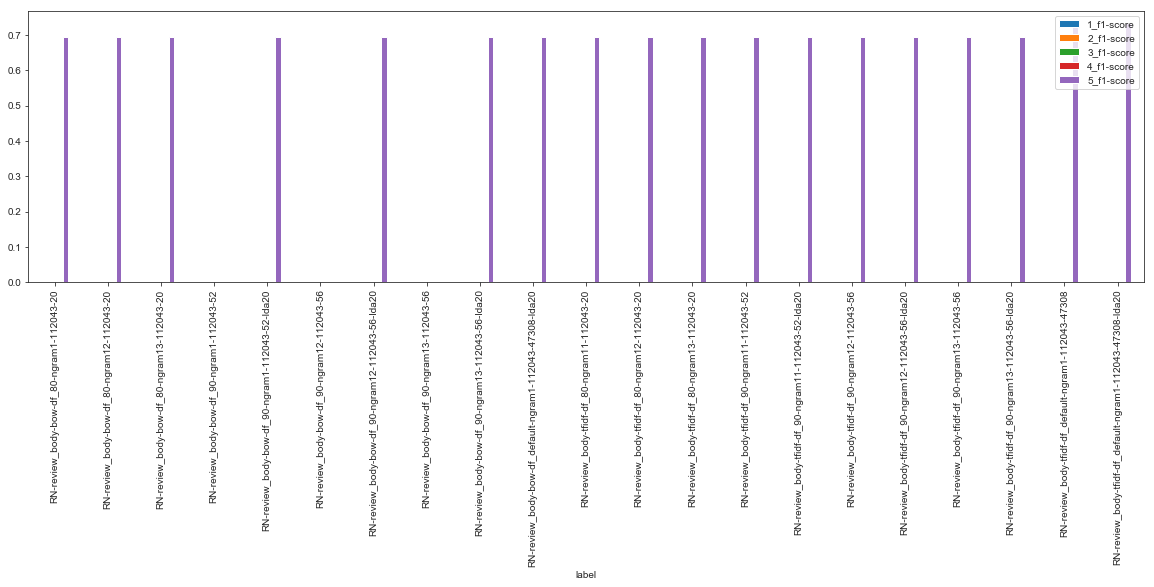

In [15]:
model_count = len(MODELS)
index = 1
for model in MODELS:
    model_report = report[report["label"].str.startswith(model)]
    a = model_report[CLASS_F1_COLS].set_index("label").plot(kind='bar', figsize=(20,5))
    if index < model_count:
        a.get_xaxis().set_visible(False)
    index += 1
#     a.set_xticklabels(labels=model_report["label"], rotation=90)

## KNN seems to be doing better than the rest. Let's look at F1 scores for KNN

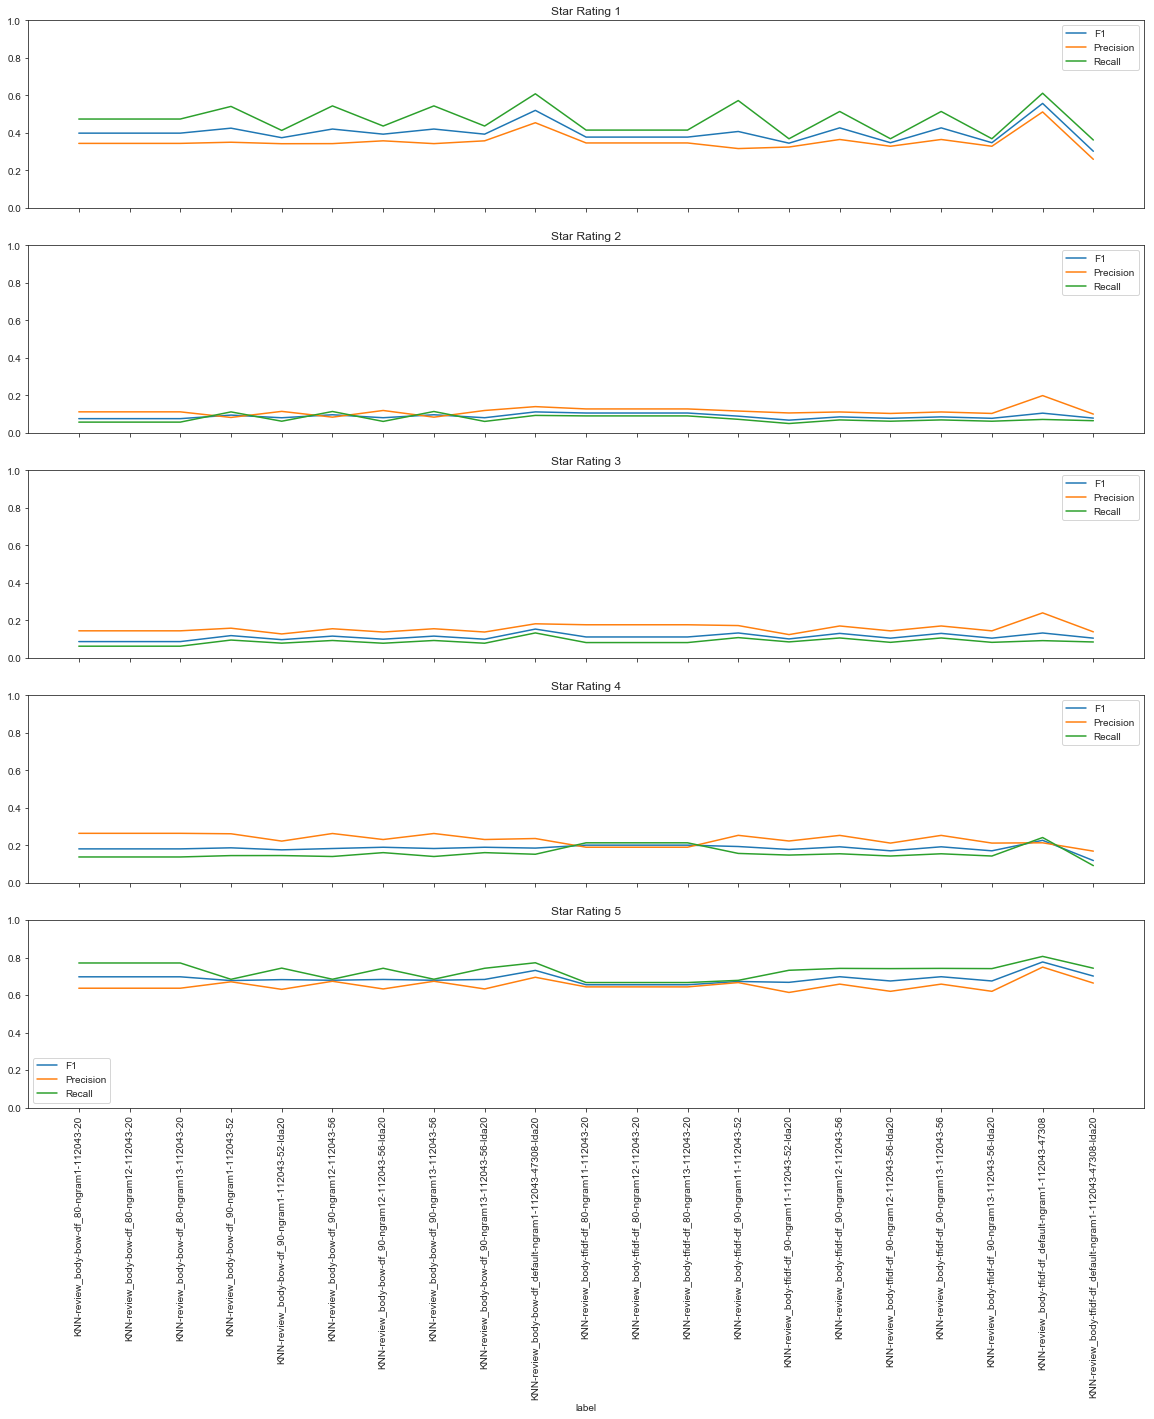

In [16]:
# graph individual stats for each rating

filter_col = [col for col in report.columns if (col.find("score") > -1 or 
                                                col.find("precision") > -1 or
                                                col.find("recall") > -1)]
filter_col.append("label")
knn_report = report[filter_col]
knn_report = knn_report[knn_report["label"].str.startswith("KNN")]


f, a = plt.subplots(5, 1, sharex=True, figsize=(20,20))


for i in range(0,5):
    g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_f1-score", label="F1", ax=a[i])
    g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_precision", label="Precision", ax=a[i])
    g = sns.lineplot(data=knn_report, x="label", y=f"{i+1}_recall", label="Recall", ax=a[i])
    _ = g.set_title(f"Star Rating {i+1}")
    a[i].set_ylim(0,1.0)
    a[i].set_ylabel("")

_ = g.set_xticklabels(labels=knn_report["label"], rotation=90)


## Let's look at top 5 KNN models - based on F1 Score

In [17]:
# cols = [col for col in f1_KNN.columns if col.startswith("macro f1") > 1]
largest = report.nlargest(5, "macro avg_f1-score")
largest_labels = largest["label"].tolist()
largest_avg_f1 = report[report["label"].isin(largest_labels)].sort_values("macro avg_f1-score", ascending=True)
largest_avg_f1[["macro avg_f1-score", "label", "total_time_min"]].head()

,macro avg_f1-score,label,total_time_min
48,0.305915,KNN-review_body-tfidf-df_90-ngram12-112043-56,1.1
51,0.305915,KNN-review_body-tfidf-df_90-ngram13-112043-56,1.1
57,0.339843,KNN-review_body-bow-df_default-ngram1-112043-47308-lda20,0.1
60,0.359072,KNN-review_body-tfidf-df_default-ngram1-112043-47308,21.8
62,0.412089,LR-review_body-tfidf-df_default-ngram1-112043-47308,37.0


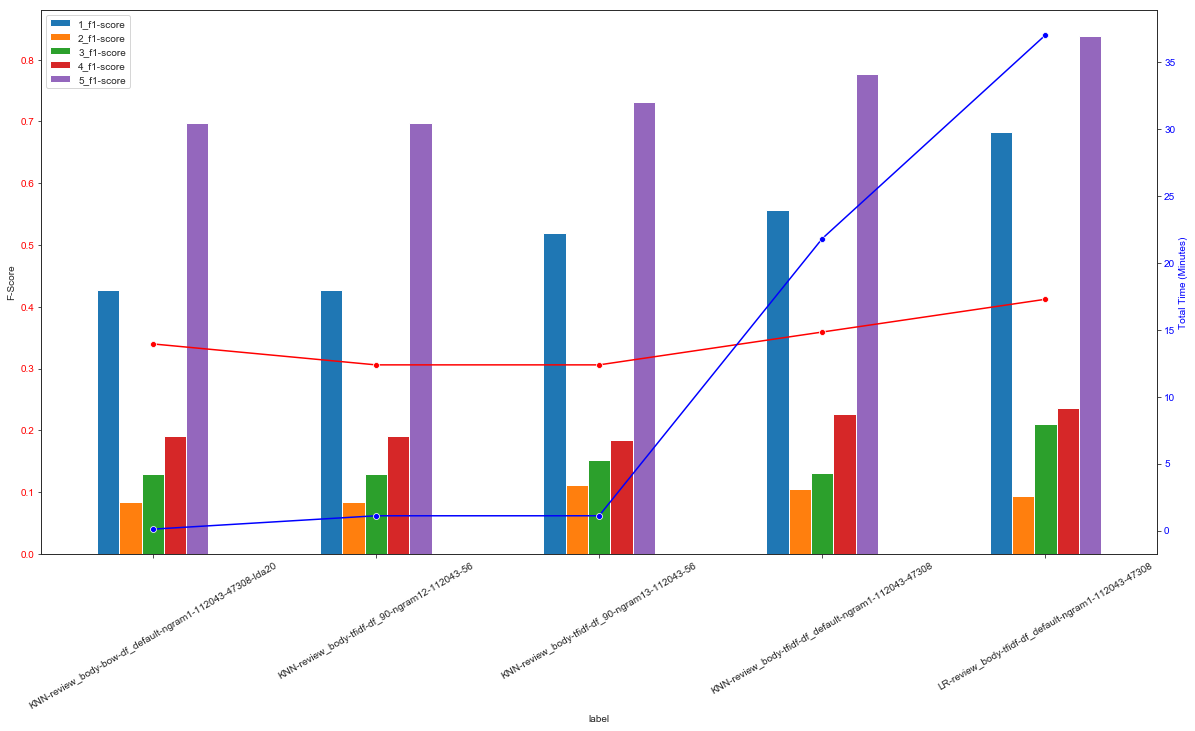

In [18]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_F1_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_f1-score", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("F-Score")
a.tick_params(axis='y', labelcolor="r")
a.set_xticklabels(labels=largest_avg_f1["label"], rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")


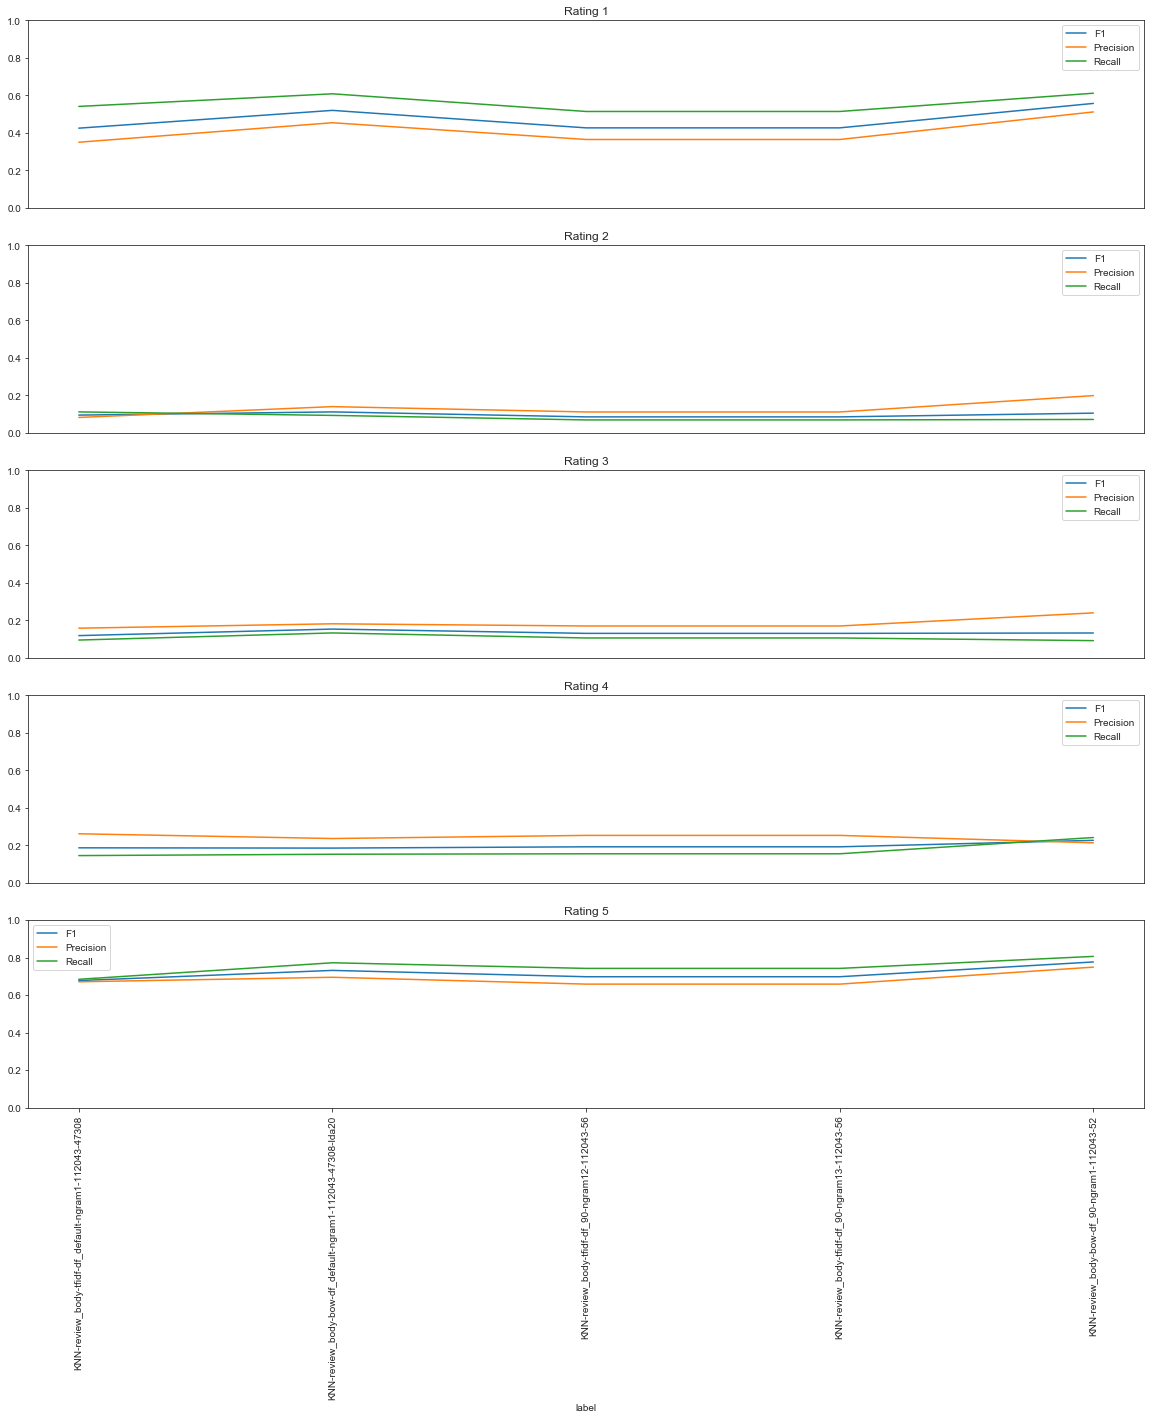

In [20]:
filter_col = [col for col in report.columns if (col.find("score") > -1 or 
                                                col.find("precision") > -1 or
                                                col.find("recall") > -1)]
filter_col.append("label")
knn_largest_scores = report[filter_col]
knn_largest_scores = knn_largest_scores[knn_largest_scores["label"].str.startswith("KNN")].nlargest(5, ["1_f1-score", "2_f1-score", "3_f1-score", "4_f1-score", "5_f1-score"])

f, a = plt.subplots(5, 1, sharex=True, figsize=(20,20))
g = sns.lineplot(data=knn_largest_scores, x="label", y="1_f1-score", label="F1", ax=a[0])
g = sns.lineplot(data=knn_largest_scores, x="label", y="1_precision", label="Precision", ax=a[0])
g = sns.lineplot(data=knn_largest_scores, x="label", y="1_recall", label="Recall", ax=a[0])
_ = g.set_title("Rating 1")
a[0].get_xaxis().set_visible(False)
a[0].set_ylim(0,1.0)
a[0].set_ylabel("")

g = sns.lineplot(data=knn_largest_scores, x="label", y="2_f1-score", label="F1", ax=a[1])
g = sns.lineplot(data=knn_largest_scores, x="label", y="2_precision", label="Precision", ax=a[1])
g = sns.lineplot(data=knn_largest_scores, x="label", y="2_recall", label="Recall", ax=a[1])
_ = g.set_title("Rating 2")
a[1].get_xaxis().set_visible(False)
a[1].set_ylim(0,1.0)
a[1].set_ylabel("")

g = sns.lineplot(data=knn_largest_scores, x="label", y="3_f1-score", label="F1", ax=a[2])
g = sns.lineplot(data=knn_largest_scores, x="label", y="3_precision", label="Precision", ax=a[2])
g = sns.lineplot(data=knn_largest_scores, x="label", y="3_recall", label="Recall", ax=a[2])
_ = g.set_title("Rating 3")
a[2].get_xaxis().set_visible(False)
a[2].set_ylim(0,1.0)
a[2].set_ylabel("")

g = sns.lineplot(data=knn_largest_scores, x="label", y="4_f1-score", label="F1", ax=a[3])
g = sns.lineplot(data=knn_largest_scores, x="label", y="4_precision", label="Precision", ax=a[3])
g = sns.lineplot(data=knn_largest_scores, x="label", y="4_recall", label="Recall", ax=a[3])
_ = g.set_title("Rating 4")
a[3].get_xaxis().set_visible(False)
a[3].set_ylim(0,1.0)
a[3].set_ylabel("")

g = sns.lineplot(data=knn_largest_scores, x="label", y="5_f1-score", label="F1", ax=a[4])
g = sns.lineplot(data=knn_largest_scores, x="label", y="5_precision", label="Precision", ax=a[4])
g = sns.lineplot(data=knn_largest_scores, x="label", y="5_recall", label="Recall", ax=a[4])
_ = g.set_title("Rating 5")
a[4].set_ylim(0,1.0)
a[4].set_ylabel("")

_ = g.set_xticklabels(labels=knn_largest_scores["label"], rotation=90)